## Requirements

In [2]:
# Import all required libraries
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
i = complex(0,1)
np.random.seed(8309)

# Import all functions from custom modules
from Load_data_yfiance import get_data
from Fit_interp_regres import get_interp
from plot_2_interp import plot_two_interp
from plot_loc_vol_surface import plot_local_vol_surface
from heston import heston_simulation, fit_Heston_model
from dupire import get_local_vol_surface, dupire_simulation

## Load Data

In [3]:
spx = yf.Ticker("^SPX")
r = 0.045
import datetime

# Get today's date
today = datetime.date.today()
if today.weekday() == 5:  # Saturday
    Today = (today - datetime.timedelta(days=1)).isoformat()
elif today.weekday() == 6:  # Sunday
    Today = (today - datetime.timedelta(days=2)).isoformat()
else:
    Today = today.isoformat()


calls,option = get_data(Ticker = spx, r = r, Today = Today)
print("range of strike: ",calls["strike"].min(),calls["strike"].max())
print("range of ttm: ",calls["ttm"].min(),calls["ttm"].max())
print("number of options: ",calls.size)
calls.head()

range of strike:  5300.0 6980.0
range of ttm:  0.003968253968253968 1.4047619047619047
number of options:  3510


,strike,lastPrice,lastTradeDate,CP,exp,S0,ttm,exp_month,r,in_out,F,q,imp_vol
0,5300.0,1538.06,2025-10-27 02:02:12+00:00,0,2025-10-28,6791.689941,0.003968,2510,0.045,in,6870.357378,-2.857115,2.925728
1,6700.0,146.20,2025-10-27 03:31:37+00:00,0,2025-10-28,6791.689941,0.003968,2510,0.045,in,6870.357378,-2.857115,0.545276
2,6710.0,136.35,2025-10-27 03:31:37+00:00,0,2025-10-28,6791.689941,0.003968,2510,0.045,in,6870.357378,-2.857115,0.523612
3,6720.0,122.60,2025-10-27 00:23:02+00:00,0,2025-10-28,6791.689941,0.003968,2510,0.045,in,6870.357378,-2.857115,0.477092
4,6730.0,112.00,2025-10-27 01:28:22+00:00,0,2025-10-28,6791.689941,0.003968,2510,0.045,in,6870.357378,-2.857115,0.450157


# Local Volitality Method

## Get Interpolation and Regression (as comparison)

In [4]:
interp,regres = get_interp(calls)
plot_two_interp(interp,regres,calls)

## Find and Plot Local Volitality

### Local Vol using Interpolation

In [5]:
impvol_interp = interp
params = [calls["S0"].iloc[0],calls["r"].iloc[0],impvol_interp]
local_vol_surface = get_local_vol_surface(calls,params)
plot_local_vol_surface(calls,local_vol_surface)


### local Vol using regression

In [6]:
impvol_interp = regres
params = [calls["S0"].iloc[0],calls["r"].iloc[0],impvol_interp]
local_vol_surface_ = get_local_vol_surface(calls,params)
plot_local_vol_surface(calls,local_vol_surface_)

# Heston Method

## Fit Heston Model

In [7]:
v0,kappa,theta,rho,sigma = fit_Heston_model(calls)
print("initial variance under risk-neutral dynamics")
print("v0:", v0)
print("rate of mean reversion of variance under risk-neutral dynamics")
print("kappa:", kappa)
print("long-term mean of variance under risk-neutral dynamics")
print("theta:", theta)
print("correlation between returns and variances under risk-neutral dynamics")
print("rho:", rho)
print("volatility of volatility")
print("sigma:", sigma)

initial variance under risk-neutral dynamics
v0: 0.02
rate of mean reversion of variance under risk-neutral dynamics
kappa: 2.0
long-term mean of variance under risk-neutral dynamics
theta: 0.02
correlation between returns and variances under risk-neutral dynamics
rho: -0.5
volatility of volatility
sigma: 0.02


# Plot simulated path

## Set Up parameters

In [8]:
# Exercise price
K = 6000
# time in years
T = 0.5
# number of time steps in simulation
N = int(T*252)
# asset price
S0 = calls["S0"].iloc[0]
# risk-free rate
r = calls["r"].iloc[0]
# Divident rate <---------- need to double check
q = 0
# number of simulations
M = 100


## Plot Paths

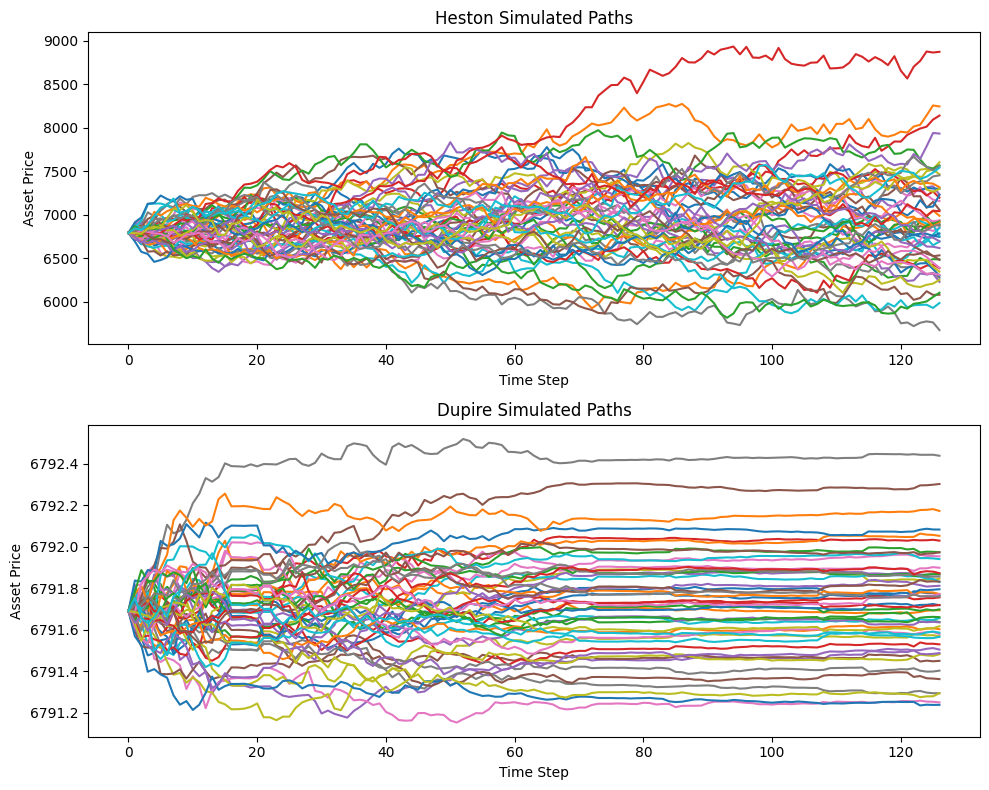

In [ ]:
S_path_Heston,V_path_Heston = heston_simulation(S0=S0,r=r,q=q,K=K,T=T,v0=v0,kappa=kappa,theta=theta,rho=rho,sigma=sigma,paths=M,steps=N)
S_path_dupire,V_path_dupire = dupire_simulation(K=K,S0=S0,T=T,N=N,M=M, params=[calls["S0"].iloc[0],calls["r"].iloc[0],regres])

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(S_path_Heston[:,:50])
axs[0].set_title("Heston Simulated Paths")
axs[0].set_xlabel("Time Step")
axs[0].set_ylabel("Asset Price")

axs[1].plot(S_path_dupire[:,:50])
axs[1].set_title("Dupire Simulated Paths")
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Asset Price")

plt.tight_layout()
plt.show()


## Garch Method